In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Step 1: Load the dataset
Liver_df = pd.read_csv('indian_liver_patient.csv', skipinitialspace=True) #skipinitialspace for the gender column
# Liver_df['Selector'] = Liver_df['Selector'] - 1

# Liver_df = pd.concat([Liver_df] * 4, ignore_index=True)
Liver_df.isna().sum()

age                           0
gender                        0
total_bilirubin               0
direct_bilirubin              0
alkaline_phosphotase          0
alamine_aminotransferase      0
aspartate_aminotransferase    0
total_protiens                0
albumin                       0
albumin_and_globulin_ratio    4
dataset                       0
dtype: int64

In [2]:

# Step 2: Fill missing values in 'A/G Ratio' based on correlation with 'ALB'
# def fill_agr_missing(row):
#     if pd.isnull(row['albumin_and_globulin_ratio']):
#         return row['albumin'] * correlation
#     return row['albumin_and_globulin_ratio']

# non_null_df = Liver_df.dropna(subset=['albumin', 'albumin_and_globulin_ratio'])
# correlation = non_null_df['albumin'].corr(non_null_df['albumin_and_globulin_ratio'])
# Liver_df['albumin_and_globulin_ratio'] = Liver_df.apply(fill_agr_missing, axis=1)
Liver_df.dropna(subset=['albumin_and_globulin_ratio'], inplace=True)


In [3]:

# Step 3: Encode gender to numeric values
Liver_df["gender"] = Liver_df["gender"].map({'Male': 0, 'Female': 1})
Liver_df

,age,gender,total_bilirubin,direct_bilirubin,alkaline_phosphotase,alamine_aminotransferase,aspartate_aminotransferase,total_protiens,albumin,albumin_and_globulin_ratio,dataset
0,65,1,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,0,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,0,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,0,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,0,3.9,2.0,195,27,59,7.3,2.4,0.40,1
...,...,...,...,...,...,...,...,...,...,...,...
578,60,0,0.5,0.1,500,20,34,5.9,1.6,0.37,2
579,40,0,0.6,0.1,98,35,31,6.0,3.2,1.10,1
580,52,0,0.8,0.2,245,48,49,6.4,3.2,1.00,1
581,31,0,1.3,0.5,184,29,32,6.8,3.4,1.00,1


In [4]:
# Step 4: Identify and remove outliers using the IQR method
Indexes = []

for col in Liver_df.columns:
    q1 = Liver_df[col].quantile(0.10)
    q3 = Liver_df[col].quantile(0.90)
    iqr = q1 - q3
    outlier_step = 1.5
    lowerLimit, upperLimit = q1+outlier_step*iqr, q3-outlier_step*iqr

    outliers = Liver_df.loc[(Liver_df[col]<lowerLimit) | (Liver_df[col]>upperLimit)].index

    for ele in outliers:
        if ele not in Indexes:
            Indexes.append(ele)

df_clean = Liver_df.drop(index=Indexes)
df_clean

,age,gender,total_bilirubin,direct_bilirubin,alkaline_phosphotase,alamine_aminotransferase,aspartate_aminotransferase,total_protiens,albumin,albumin_and_globulin_ratio,dataset
0,65,1,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,0,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,0,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,0,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,0,3.9,2.0,195,27,59,7.3,2.4,0.40,1
...,...,...,...,...,...,...,...,...,...,...,...
578,60,0,0.5,0.1,500,20,34,5.9,1.6,0.37,2
579,40,0,0.6,0.1,98,35,31,6.0,3.2,1.10,1
580,52,0,0.8,0.2,245,48,49,6.4,3.2,1.00,1
581,31,0,1.3,0.5,184,29,32,6.8,3.4,1.00,1


In [5]:

# Step 5: Impute missing values with median
imputer = SimpleImputer(strategy='median')
df_filled = pd.DataFrame(imputer.fit_transform(df_clean), columns=df_clean.columns)


In [6]:

# Step 6: Split features and target variable
# Liver_df_expanded = df_filled.drop(["DB"], axis=1)
# Liver_df_expanded.rename(columns={'Selector': 'Outcome'}, inplace=True)
# y = Liver_df_expanded['Outcome'].copy()
# X = Liver_df_expanded.drop('Outcome', axis=1)
y = Liver_df['dataset'].copy()
X = Liver_df.drop('dataset', axis=1)


In [7]:

# Step 7: Normalization/Standardization
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 8 Balance classes using SMOTE
X_balanced, y_balanced = SMOTE().fit_resample(X, y)


In [8]:
from sklearn.pipeline import Pipeline

# Split the data into training, validation, and test sets (60% train, 20% validation, 20% test)
# X_train, X_temp, y_train, y_temp = train_test_split(X_balanced, y_balanced, test_size=0.4, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Build the Random Forest model within a pipeline with StandardScaler and RandomForestClassifier
model = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=42))
])

# Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Mean Accuracy:", cv_scores.mean())

# Train the model on the entire training set
model.fit(X_train, y_train)

# Evaluate the model on the validation set
# y_pred_val = model.predict(X_val)
# accuracy_val = accuracy_score(y_val, y_pred_val)
# print("Validation Accuracy:", accuracy_val)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy_test)


Cross-Validation Mean Accuracy: 0.7991341991341991
Test Accuracy: 0.8313253012048193


In [9]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


# Define models with hyperparameter grids
models = {
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "model__n_estimators": [50, 100, 200],
            "model__max_depth": [10, 20, 30],
            "model__min_samples_leaf": [1, 2, 4],
            "model__min_samples_split": [2, 5, 10]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "model__n_estimators": [50, 100, 200],
            "model__max_depth": [3, 5, 7],
            "model__min_samples_split": [2, 5, 10],
            "model__min_samples_leaf": [1, 2, 4],
            "model__learning_rate": [0.01, 0.1, 0.5]
        }
    }
}

# Train and evaluate each model with hyperparameter tuning
for name, model_info in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model_info["model"])
    ])
    clf = GridSearchCV(pipeline, model_info["params"], cv=5, scoring='accuracy', n_jobs=-1)
    clf.fit(X_train, y_train)
    
    # Print best parameters
    print(f"{name} Best Parameters:", clf.best_params_)

    # Evaluate on validation set
    # y_pred_val = clf.predict(X_val)
    # accuracy_val = accuracy_score(y_val, y_pred_val)
    # print(f"{name} Validation Accuracy:", accuracy_val)

    # Evaluate on test set
    y_pred = clf.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_pred)
    print(f"{name} Test Accuracy:", accuracy_test)


Random Forest Best Parameters: {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 50}
Random Forest Test Accuracy: 0.8072289156626506
Gradient Boosting Best Parameters: {'model__learning_rate': 0.5, 'model__max_depth': 7, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 100}
Gradient Boosting Test Accuracy: 0.8373493975903614


In [10]:
# Define Gradient Boosting model with specified hyperparameters
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

# model = GradientBoostingClassifier(learning_rate=0.5, max_depth=7, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=42)
model = GradientBoostingClassifier(learning_rate=0.5, max_depth=7, min_samples_leaf=2, min_samples_split=5, n_estimators=50, random_state=42)

# Build the model within a pipeline with StandardScaler
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', model)
])

# Train the model on the entire training set
pipeline.fit(X_train, y_train)

# Evaluate the model on the validation set
# y_pred_val = pipeline.predict(X_val)
# accuracy_val = accuracy_score(y_val, y_pred_val)
# print("Validation Accuracy:", accuracy_val)

# Evaluate the model on the test set
y_pred = pipeline.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy_test)


Test Accuracy: 0.8192771084337349


Text(95.72222222222221, 0.5, 'Truth Values')

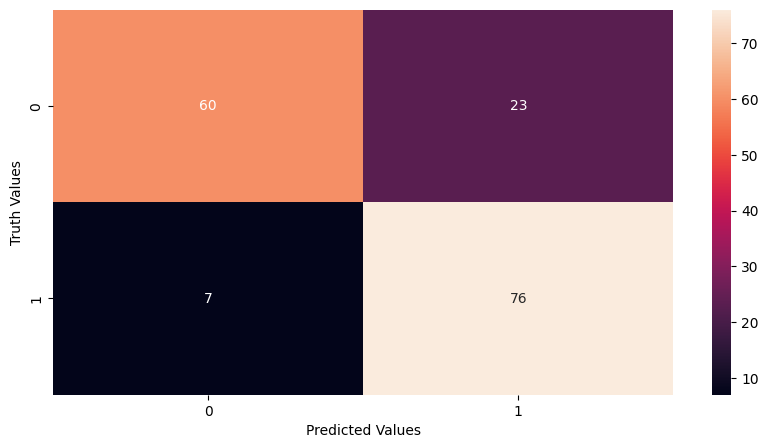

In [11]:
from sklearn.metrics import confusion_matrix  
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,5))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted Values')
plt.ylabel('Truth Values')

In [12]:
# SAVING THE MODEL USING PICKLE PACKAGE

import pickle

# save the iris classification model as a pickle file
model_pkl_file = "./liver-gbc.pkl"

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model, file)